$c \sim \mathrm{Normal}(10, 1)$

$\mu(\lambda) = c\cdot\epsilon(\lambda)$

$y \sim \mathrm{Normal}(f(\mu), f_\sigma(\mu))$

In [1]:
import numpy as np
import json
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow import keras
from tensorflow.keras import layers
import gpflow
import matplotlib.pyplot as plt

from helpers.interpolate_extinction_coeffs import extinction_coeffs

# some initial setup

wavelengths, coeffs = extinction_coeffs()
wavelengths, coeffs = tf.constant(wavelengths), tf.constant(coeffs.T)

# importing data

with open('./results/fixed_n30.json', 'r') as f:
    data = json.load(f)

data = [e for e in data if e['reflectance'] > 0] # filter out simulations with 0 reflectance

reflectance = np.array([e['reflectance'] for e in data])[:, None]

build_var = lambda l_i, name: { 'layer': l_i, 'name': name }

relevant_vars = [
    (0, 'height'),
    (1, 'height'),
    (0, 'muA'),
    (2, 'muA'),
    (0, 'muS'),
    (2, 'muS')
]
relevant_data = np.array([np.array([e['layers'][i][key] for i, key in relevant_vars]) for e in data])

# try this sort of thing (log transform) if not having much luck
#relevant_data[:, 2:7] = np.log(relevant_data[:, 2:7])

# create a normalizer

x_norm = layers.Normalization(axis=-1)
x_norm.adapt(relevant_data)

y_max = tf.reduce_max(reflectance) # norm factor

gp_x = tf.cast(x_norm(relevant_data), tf.float64)
gp_y = reflectance / y_max

y_inv_trans = lambda y_prime: tf.math.exp(y_prime)

relevant_data.dtype, reflectance.dtype, gp_x.dtype, gp_y.dtype, relevant_data.shape

2023-03-23 15:27:19.817513: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-23 15:27:21.413590: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-23 15:27:21.413808: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-03-23 15:27:26.160891: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

ModuleNotFoundError: No module named 'gpflow'

In [ ]:
sims_to_use = 1719

lengthscales_start = np.repeat(1, len(gp_x[1]))

gp_model = gpflow.models.GPR(
    (gp_x[:sims_to_use, :], gp_y[:sims_to_use, :]),
    kernel=gpflow.kernels.SquaredExponential(lengthscales=lengthscales_start),
    noise_variance=1e-3
)

gpflow.set_trainable(gp_model.likelihood.variance, False)
print(gp_model.likelihood.variance)
"""
opt = gpflow.optimizers.Scipy()
opt.minimize(gp_model.training_loss, gp_model.trainable_variables)
"""

opt = tf.keras.optimizers.Adam(learning_rate=0.1)

@tf.function
def step() -> tf.Tensor:
    opt.minimize(gp_model.training_loss, gp_model.trainable_variables)


gp_losses = []
maxiter = 2_000
for i in range(maxiter):
    step()
    loss = gp_model.training_loss().numpy()
    gp_losses.append(loss)
    print(i, loss)


gpflow.utilities.print_summary(gp_model)

gp_model.parameters

<Parameter: name=chain_of_shift_of_softplus, dtype=float64, shape=[], fn="chain_of_shift_of_softplus", numpy=0.0010000000000000002>
0 -1003.7515640007848
1 -1275.9818248696433
2 -1529.6718124487304
3 -1761.5492079491019
4 -1969.3999410312542
5 -2152.385378398658
6 -2311.01835185382
7 -2446.7666447027377
8 -2561.6305477135047
9 -2657.8796561172157
10 -2737.905494127196
11 -2804.1047031987373
12 -2858.765077928976
13 -2903.9682291478866
14 -2941.5287600421166
15 -2972.976205639874
16 -2999.570806751238
17 -3022.3378203023376
18 -3042.1071348278297
19 -3059.5503320105868
20 -3075.2119905873396
21 -3089.5347099879878
22 -3102.8784464093505
23 -3115.5350532923703
24 -3127.7389297841073
25 -3139.674679597431
26 -3151.4827873498134
27 -3163.2645347636944
28 -3175.0875722740648
29 -3186.9934419587416
30 -3199.0075496837308
31 -3211.1504163884947
32 -3223.4468200790952
33 -3235.9276948728716
34 -3248.619991408538
35 -3261.523937409328
36 -3274.5862478661534
37 -3287.6887651451298
38 -3300.67318

In [ ]:
gpflow.utilities.print_summary(gp_model)

gp_model.parameters

╒════════════════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤═══════════════════════════════╕
│ name                               │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │ value                         │
╞════════════════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪═══════════════════════════════╡
│ GPR.kernel.kernels[0].variance     │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 6.46398                       │
├────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼───────────────────────────────┤
│ GPR.kernel.kernels[0].lengthscales │ Parameter │ Softplus         │         │ True        │ (6,)    │ float64 │ [1.42834, 1.19265, 2.89687... │
├────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼───────────

(<Parameter: name=softplus, dtype=float64, shape=[6], fn="softplus", numpy=
 array([1.428342  , 1.19264705, 2.89687436, 1.00793101, 0.93452599,
        1.0573112 ])>,
 <Parameter: name=softplus, dtype=float64, shape=[], fn="softplus", numpy=6.463984585668348>,
 <Parameter: name=softplus, dtype=float64, shape=[], fn="softplus", numpy=7.287179905666406>,
 <Parameter: name=chain_of_shift_of_softplus, dtype=float64, shape=[], fn="chain_of_shift_of_softplus", numpy=0.0010000000000000002>)

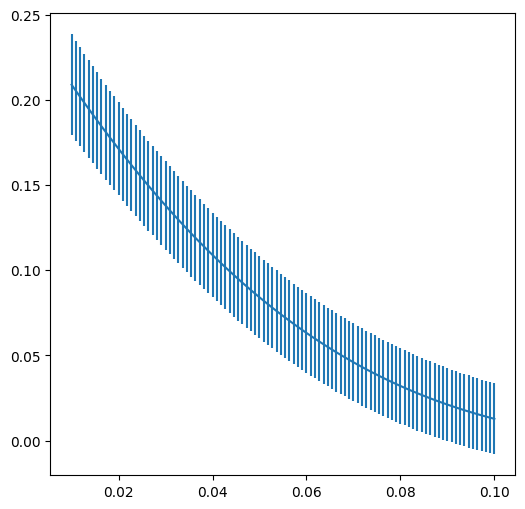

array([0.14169156, 0.14295779, 0.14429193, 0.14569539, 0.14716961,
       0.14871602, 0.15033609, 0.15203133, 0.15380324, 0.15565339,
       0.15758337, 0.15959481, 0.16168939, 0.16386882, 0.16613491,
       0.16848947, 0.17093441, 0.17347168, 0.17610333, 0.17883149,
       0.18165836, 0.18458624, 0.18761751, 0.19075471, 0.19400042,
       0.19735739, 0.2008285 , 0.20441672, 0.20812522, 0.21195731,
       0.21591645, 0.22000626, 0.22423057, 0.22859342, 0.23309902,
       0.23775185, 0.24255656, 0.24751809, 0.25264163, 0.25793268,
       0.26339696, 0.26904056, 0.2748699 , 0.28089176, 0.28711324,
       0.29354187, 0.30018562, 0.3070529 , 0.3141526 , 0.32149405,
       0.32908722, 0.3369426 , 0.34507134, 0.35348515, 0.36219654,
       0.37121874, 0.38056579, 0.3902525 , 0.40029472, 0.41070923,
       0.42151386, 0.4327276 , 0.44437065, 0.45646462, 0.46903226,
       0.48209812, 0.49568833, 0.50983077, 0.52455528, 0.53989385,
       0.55588061, 0.57255241, 0.58994835, 0.60811085, 0.62708

In [ ]:
no_changes = 100

data_point_i = 1
data_point = relevant_data[data_point_i]
initial_absorption = data_point[2]
data_point = np.array([data_point]).repeat(no_changes, axis=0)
#data_point = np.broadcast_to(data_point, (no_changes, relevant_data.shape[1]))

# ln(0.01) - ln(0.1): -4.6 - -2.3
ln_absorption = np.linspace(0.001, 0.1, no_changes)

data_point[:, 2] = ln_absorption

data_point = tf.cast(x_norm(data_point), tf.float64)
reflectance_norm = gp_model.predict_f(data_point)
means, std = reflectance_norm[0].numpy().flatten(), np.sqrt(reflectance_norm[1].numpy().flatten())


plt.figure(figsize=(6,6))
#plt.errorbar(ln_absorption + initial_absorption, means, std)
plt.errorbar(ln_absorption, means, std)
#plt.xscale('log')
#plt.yscale('log')
plt.show()

percent_error = std / means

percent_error

In [ ]:
class Distance(tf.keras.layers.Layer):
    def __init__(self, coeffs, wavelengths, gp_model, **kwargs):
        super().__init__(**kwargs)

        self.coeffs = coeffs
        self.wavelengths = wavelengths
        self.n_wavelengths = tf.size(wavelengths)

        gpflow.set_trainable(gp_model, False)
        self.gp_model = gp_model

        """
        self.a_s = tf.Variable([[3, 3]], dtype=tf.double, name='a')
        self.b_s = tf.Variable([1.4, 1.4], dtype=tf.double, name='b')
        self.heights_raw = tf.Variable([2, 1], dtype=tf.double, name='h')
        self.concs_raw = tf.Variable([[2, -10, -10], [10, -10, -10]], dtype=tf.double, name='c') # H2O, HbO, HHb
        """

        # scale is used for reflectance distribution 10**scale
        self.scale = tf.Variable(0, dtype=tf.double, name='scale')
        """
        self.sigmoid_bijector = tfp.bijectors.Sigmoid(low=0, high=1)
        self.S_raw = tf.Variable(0, dtype=tf.float32, name='S')
        """

    def _build_x(self, a_s, b_s, concs, heights):
        """
        # this whole bit hasn't been checked
        blood_part = concs[:, -1]

        S = self.sigmoid_bijector.forward(self.S_raw)
        blood_part = tf.cast(blood_part * tf.constant([S, 1-S]), tf.double)
        other_part = concs[:, :-1]

        concs = tf.concat([other_part, blood_part], axis=0) # check axis
        """
        
        rep_heights = tf.repeat(heights[None, :], self.n_wavelengths, axis=0)
        scattering = a_s*((self.wavelengths[:, None] / 500)**(-b_s))*10

        absorption = self.coeffs @ tf.transpose(concs)

        x = tf.concat([rep_heights, absorption, scattering], axis=1)

        return x
    
    def _predict(self, x):
        normalized = tf.cast(tf.math.log(x_norm(x)), dtype=tf.double)
        return gp_model.predict_f(normalized)
    
    def call(self, a_s, b_s, concs, heights):
        x = self._build_x(a_s, b_s, concs, heights)
        means, variances = self._predict(x)

        scale_fac = 10**self.scale

        predicted_ref = tf.concat([means, variances*scale_fac], axis=1) * scale_fac

        return predicted_ref

class CombinedModule(tf.keras.Model):
    def __init__(self, gp_model, **kwargs):
        super().__init__(**kwargs)

        self.a_s = tf.Variable([[3, 3]], dtype=tf.double, name='a', trainable=False)
        self.b_s = tf.Variable([1.4, 1.4], dtype=tf.double, name='b', trainable=False)
        self.concs_raw = tf.Variable([[3, -10, -10], [3, -10, -10]], dtype=tf.double, name='c') # H2O, HbO, HHb
        self.heights_raw = tf.Variable([2, 1], dtype=tf.double, name='h')

        self.dist_one = Distance(coeffs, wavelengths, gp_model)

    def call(self, coeffs, wavelengths):
        concs = tf.math.exp(self.concs_raw)
        heights = tf.math.exp(self.heights_raw)

        return self.dist_one(self.a_s, self.b_s, concs, heights)




model = CombinedModule(gp_model)

model.trainable_variables

[<tf.Variable 'scale:0' shape=() dtype=float64, numpy=0.0>,
 <tf.Variable 'c:0' shape=(2, 3) dtype=float64, numpy=
 array([[  3., -10., -10.],
        [  3., -10., -10.]])>,
 <tf.Variable 'h:0' shape=(2,) dtype=float64, numpy=array([2., 1.])>]

In [ ]:
wls = np.load('./data/wavelengths.npy').flatten()
spectra_3cm = np.load('./data/3cm.npy').flatten()
reference = np.load('./data/ref.npy').flatten()

min_wavelength, max_wavelength = 700, 900
refs_in_range = tf.constant([e / ref for wl, e, ref in zip(wls, spectra_3cm, reference) if wl > min_wavelength and wl < max_wavelength])

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-2)

def mse_loglike(measured, predicted):
    print('Tracing loglike!')
    diff = tf.square(predicted[:, 0] - measured)
    mse = tf.reduce_mean(diff)
    return tf.math.log(mse)

pi = tf.constant(np.pi, dtype=tf.float64)
def normal_loglike(measured, predicted):
    predicted = y_inv_trans(predicted)
    diff = tf.square(predicted[:, 0] - measured)
    chi_terms = diff / predicted[:, 1]
    chi_contrib = 0.5 * tf.reduce_sum(chi_terms)
    error_contrib = 0.5 * tf.reduce_sum(tf.math.log(2*pi*predicted[:, 1]))

    return chi_contrib + error_contrib

@tf.function
def train(refs_in_range, wavelengths, coeffs):
    print('Tracing!')
    with tf.GradientTape() as t:
        loss = normal_loglike(refs_in_range, model(coeffs, wavelengths))
    
    gradients = t.gradient(loss, model.trainable_weights)
    print(gradients)
    optimizer.apply_gradients(zip(gradients, model.trainable_weights))

    return loss

N = 1500
losses = []
for i in range(N):
    loss = train(refs_in_range, wavelengths, coeffs)
    losses.append(loss)
    print(i, loss)

losses = tf.stack(losses).numpy()

Tracing!
Tracing!
0 tf.Tensor(706.4916938583447, shape=(), dtype=float64)
1 tf.Tensor(706.4259937074694, shape=(), dtype=float64)
2 tf.Tensor(706.3657305931345, shape=(), dtype=float64)
3 tf.Tensor(706.310658875003, shape=(), dtype=float64)
4 tf.Tensor(706.2604906311152, shape=(), dtype=float64)
5 tf.Tensor(706.2148952775082, shape=(), dtype=float64)
6 tf.Tensor(706.1735005272087, shape=(), dtype=float64)
7 tf.Tensor(706.1358965490216, shape=(), dtype=float64)
8 tf.Tensor(706.1016399263261, shape=(), dtype=float64)
9 tf.Tensor(706.070263398419, shape=(), dtype=float64)
10 tf.Tensor(706.0412861710482, shape=(), dtype=float64)
11 tf.Tensor(706.0142263343735, shape=(), dtype=float64)
12 tf.Tensor(705.9886147732827, shape=(), dtype=float64)
13 tf.Tensor(705.9640092616361, shape=(), dtype=float64)
14 tf.Tensor(705.9400042777188, shape=(), dtype=float64)
15 tf.Tensor(705.9162421008335, shape=(), dtype=float64)
16 tf.Tensor(705.8924163487658, shape=(), dtype=float64)
17 tf.Tensor(705.86827508

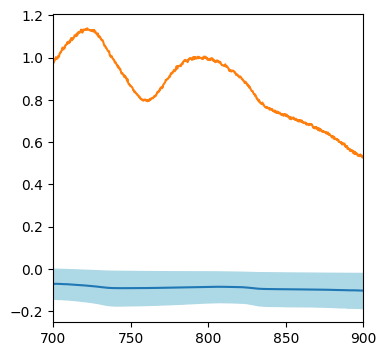

ValueError: x and y must have same first dimension, but have shapes (826,) and (1500,)

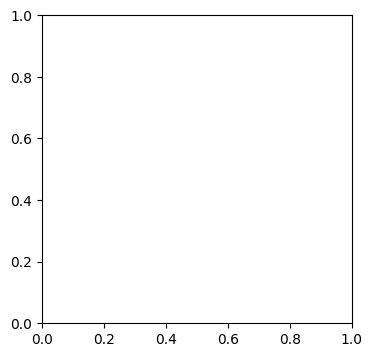

In [ ]:
plt.figure(figsize=(4,4))

result = model(coeffs, wavelengths)
mean = result[:, 0]
std = tf.math.sqrt(result[:, 1])

plt.fill_between(wavelengths, mean - std, mean + std, color='lightblue')
plt.plot(wavelengths, mean)

plt.plot(wavelengths, refs_in_range)

plt.xlim((min_wavelength, max_wavelength))
plt.show()

plt.figure(figsize=(4,4))
plt.plot(range(826), losses)
plt.show()

In [ ]:
concs = tf.math.exp(model.concs_raw).numpy()

print('Water / M', concs[:, 0])
print('HbO / uM', concs[:, 1]*1e6)
print('HHb / uM', concs[:, 2]*1e6)

heights = tf.math.exp(model.heights_raw).numpy()

print('Heights / mm', heights)

a = model.a_s.numpy()
b = model.b_s.numpy()

print('a / mm-1', a.flatten())
print('b', b)

scale = model.dist_one.scale.numpy()

print('scale', scale)

Water / M [39.1991957 24.0453644]
HbO / uM [ 55.54107324 557.2137891 ]
HHb / uM [  49.13805631 1883.91779985]
Heights / mm [ 7.28622978 11.21709632]
a / mm-1 [3. 3.]
b [1.4 1.4]
scale 1.8010320563495663
